# DAT565/DIT407 Assignment 4

Author: Group 26 | Wenjun Tian wenjunt@chalmers.se | Yifan Tang yifant@chalmers.se

Date: 2024-11-28

# Problem 1: Splitting the data

I choose an 80-20 split because it can balance between having enough data for training the model and enough data to evaluate performance. Using 80% of the data for training ensures that the model has sufficient data to learn from, and the remaining 20% is testing set which provides a reliable estimate to predict future data.

Sorting the data by time before splitting into training and testing sets ensures that the evaluation accurately reflects the model’s prediction ability. Besides, if a row has a missing year, we remove it to prevent it from affecting the predictions.

In [338]:
import pandas as pd

data = pd.read_csv('life_expectancy.csv')

# remove the lines that miss `Year`
data = data.dropna(subset=['Year']).copy()

data = data.sort_values(by='Year').copy()

split_ratio = 0.8
split_index = int(len(data) * split_ratio)

# split the data
train_data = data.iloc[:split_index].copy()
test_data = data.iloc[split_index:].copy()


# Problem 2: Single-variable model
## Question a 
 `Human Development Index (value)` is found to have the strongest linear relationship with the target variable. The Pearson product-moment correlation coefficient between `Human Development Index (value)` and LEB is 0.9185.


In [339]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# since the type of `country` is string, we try to convert it to numeric index, simplifying the calculation of correlation in `country` 
le = LabelEncoder()
combined = pd.concat([train_data['Country'], test_data['Country']], axis=0)
le.fit(combined)
train_data.loc[:, 'Country'] = le.transform(train_data['Country'])
test_data.loc[:, 'Country'] = le.transform(test_data['Country'])

# calculate correlation
target = 'Life Expectancy at Birth, both sexes (years)'

pearson_corr_list = []
max_corr_value = -1
corr_var = None

for feature in train_data.columns:
    if feature != target:
        corr = train_data[[feature, target]].corr().iloc[0, 1]
        pearson_corr_list.append({'Feature': feature, 'Correlation': corr})
        if abs(corr) > max_corr_value:
            max_corr_value = abs(corr)
            corr_var = feature

pearson_corr_df = pd.DataFrame(pearson_corr_list)
pearson_corr_df = pearson_corr_df.sort_values(by='Correlation', ascending=False)

print(f"The variable with the strongest linear relationship with LEB is: {corr_var}")
print(f"The Pearson correlation coefficient is: {max_corr_value}")

The variable with the strongest linear relationship with LEB is: Human Development Index (value)
The Pearson correlation coefficient is: 0.9185265785149185


## Question b

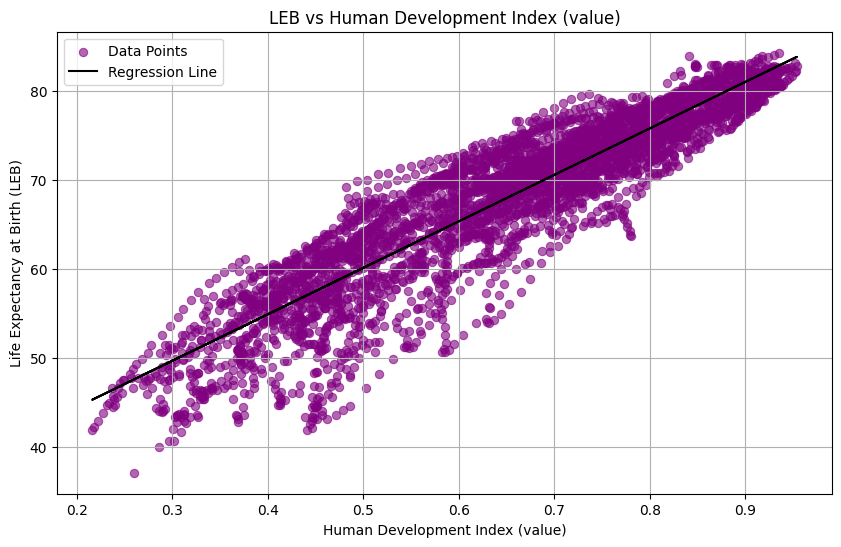

Coefficient of Determination: 0.8436910754383214
Intercept: 34.022227245635975
Coeffient for Human Development Index (value): 52.19431814091418


In [340]:
x_train = train_data[[corr_var]]
y_train = train_data[target]

model = LinearRegression()

# fit the model to the training data
model.fit(x_train, y_train)

intercept = model.intercept_
slope = model.coef_[0]

# calculate the coefficient of determination (R²)
r_squared = model.score(x_train, y_train)

# plot a scatter plot with the regression line
plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color='purple', label='Data Points',linewidth=0.8, alpha=0.6)
plt.plot(x_train, model.predict(x_train), color='black', label='Regression Line')
plt.xlabel(corr_var)
plt.ylabel('Life Expectancy at Birth (LEB)')
plt.title(f'LEB vs {corr_var}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Coefficient of Determination: {r_squared}")
print(f"Intercept: {intercept}")
print(f"Coeffient for {corr_var}: {slope}")

## Question c

In [342]:
from sklearn.metrics import mean_squared_error

x_test = test_data[[corr_var]]
y_test = test_data[target]

# drop data that has missing column
test_data = test_data.dropna(subset=[corr_var, target])

y_pred = model.predict(x_test)

# calculate Pearson Correlation Coefficient
correlation = np.corrcoef(y_test, y_pred)[0, 1]

# calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"Mean Squared Error (MSE) on test set: {mse}")

Pearson Correlation Coefficient: 0.9123752336711312
Mean Squared Error (MSE) on test set: 10.726081857852574


## Question d

> Published on 4 November 2010 (and updated on 10 June 2011), the 2010 Human Development Report calculated the HDI combining three dimensions:
> A long and healthy life: Life expectancy at birth
> Education: Mean years of schooling and expected years of schooling.
> A decent standard of living: GNI per capita (PPP international dollars)
> -- from wikipedia [Human Development Index](https://en.wikipedia.org/wiki/Human_Development_Index)


Life expectancy at birth is used as the indicator for the health dimension in the HDI. This means any changes in LEB will directly influence the HDI value. Countries with higher life expectancy contribute positively to their HDI score, reflecting better health outcomes. On the other hand, country with higher HDI may perform better in health dimension and the residents tend to have longer life expectany.


# Problem 3: Non-linear relationship
We choose the veriable with the hignest Spearman correlations as the candidate feature and plot it.
After plotting it, we assume that this is a logarithmic function and transform the data. Before transformation, Pearson correlation is `0.644`. After transformation, Pearson correlation is `0.833`.

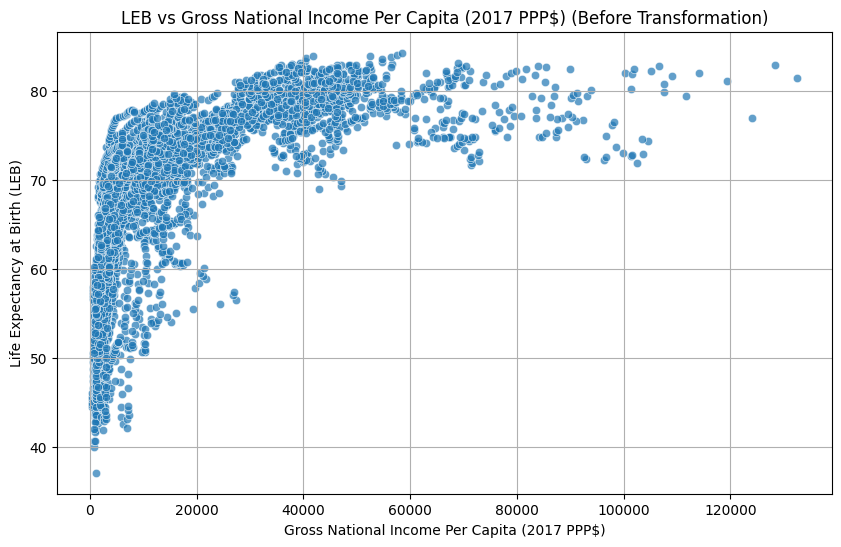

The found variable: Gross National Income Per Capita (2017 PPP$)
The function is logarithmic function
Pearson Correlation Coefficient before transformation: 0.6445383247179627
Pearson Correlation Coefficient after transformation: 0.8332246491183795


In [343]:
import seaborn as sns

features = train_data.columns.tolist()
features.remove(target)

correlation_dfs = []

# calculate correlations
for feature in features:
    if feature == 'Human Development Index (value)': 
        continue
    pearson_corr = train_data[feature].corr(train_data[target], method='pearson')
    spearman_corr = train_data[feature].corr(train_data[target], method='spearman')
    temp_df = pd.DataFrame({
        'Feature': [feature],
        'Pearson': [pearson_corr],
        'Spearman': [spearman_corr]
    })
    correlation_dfs.append(temp_df)

# Concatenate all individual DataFrames into one
correlation_df = pd.concat(correlation_dfs, ignore_index=True)

# Display the correlation DataFrame sorted by Spearman correlation
correlation_df_sorted = correlation_df.sort_values(by='Spearman', ascending=False).reset_index(drop=True)

# choose the feature with the highest Spearman correlation coefficient
candidate_feature = correlation_df_sorted.iloc[0]['Feature']

# plot a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data[candidate_feature], y=train_data[target], alpha=0.7)
plt.title(f'LEB vs {candidate_feature} (Before Transformation)')
plt.xlabel(candidate_feature)
plt.ylabel('Life Expectancy at Birth (LEB)')
plt.grid(True)
plt.show()

transformed_feature = train_data[candidate_feature]

# transform the data 
train_data.loc[:, 'Transformed_' + candidate_feature] = np.log(transformed_feature)

transformed_feature_name = 'Transformed_' + candidate_feature

correlation_before = np.corrcoef(train_data[candidate_feature], train_data[target])[0, 1]
correlation_after = np.corrcoef(train_data[transformed_feature_name], train_data[target])[0, 1]

print(f"The found variable: {candidate_feature}")
print(f"The function is logarithmic function")
print(f"Pearson Correlation Coefficient before transformation: {correlation_before}")
print(f"Pearson Correlation Coefficient after transformation: {correlation_after}")


# Problem 4: Multiple linear regression

Before selecting the best feature subset, we sort the Pearson Correlation by absolute value. Then we try choose the first ten data, which may have the strongest relation with LEB. After that, traverse every subset to pick the `best_feature_subset`.

In [ ]:
from itertools import combinations

train_data['Gross National Income Per Capita (2017 PPP$)'] = train_data['Transformed_Gross National Income Per Capita (2017 PPP$)']

# sort Pearson Correlation based on absolute value
pearson_corr_df = pearson_corr_df.reindex(pearson_corr_df['Correlation'].abs().sort_values(ascending=False).index)

# choose top 10 features
top_features = pearson_corr_df.head(10)
selected_features = top_features['Feature'].tolist()

# remove lines with missing value
train_data = train_data.dropna(subset=selected_features)
test_data = test_data.dropna(subset=selected_features)

# get train and test model
x_train_model = train_data[selected_features]
y_train_model = train_data[target]
x_test_model = test_data[selected_features]
y_test_model = test_data[target]


# select the best feature subset
best_r_squared = -float('inf')
best_feature_subset = []

# calculate R^2 to find the best feature subset
for num_features in range(1, len(selected_features) + 1):
    for feature_subset in combinations(selected_features, num_features):
        x_train_subset = train_data[list(feature_subset)]
        x_test_subset = test_data[list(feature_subset)]

        model = LinearRegression()
        model.fit(x_train_subset, y_train_model)
        r_squared = model.score(x_test_subset, y_test_model)
        
        # record best feature subset
        if r_squared > best_r_squared:
            best_r_squared = r_squared
            best_feature_subset = feature_subset

x_train_model = train_data[list(best_feature_subset)]
x_test_model = test_data[list(best_feature_subset)]

multi_var_model = LinearRegression()
multi_var_model.fit(x_train_model, y_train_model)

# calculate the intercept and coefficient
intercept = multi_var_model.intercept_
coefficients = multi_var_model.coef_

coef_df = pd.DataFrame({
    'Feature': best_feature_subset,
    'Coefficient': coefficients
})

y_pred_test = multi_var_model.predict(x_test_model)

# calculate
correlation = np.corrcoef(y_pred_test, y_test_model)[0, 1]
mse_test = mean_squared_error(y_test_model, y_pred_test)
r_squared_test = multi_var_model.score(x_test_model, y_test_model)

print(f"Selected_features: {selected_features}")
print(selected_features)
print(f"\nModel Intercept: {intercept}")
print("Model Coefficients:")
print(coef_df)
print('\n')
print(f"Coefficient of Determination (R²): {r_squared_test}")
print(f"Pearson Correlation Coefficient: {correlation}")
print(f"Mean Squared Error (MSE): {mse_test}")

Selected_features: ['Human Development Index (value)', 'Crude Birth Rate (births per 1,000 population)', 'Coefficient of human inequality', 'Total Fertility Rate (live births per woman)', 'Expected Years of Schooling, female (years)', 'Expected Years of Schooling (years)', 'Adolescent Birth Rate (births per 1,000 women ages 15-19)', 'Median Age, as of 1 July (years)', 'Expected Years of Schooling, male (years)', 'Net Reproduction Rate (surviving daughters per woman)']
['Human Development Index (value)', 'Crude Birth Rate (births per 1,000 population)', 'Coefficient of human inequality', 'Total Fertility Rate (live births per woman)', 'Expected Years of Schooling, female (years)', 'Expected Years of Schooling (years)', 'Adolescent Birth Rate (births per 1,000 women ages 15-19)', 'Median Age, as of 1 July (years)', 'Expected Years of Schooling, male (years)', 'Net Reproduction Rate (surviving daughters per woman)']

Model Intercept: 42.29299294316402
Model Coefficients:
                 